### Notebook to update dendrogram figure for paper
- Grey scale on one band or make RGB with three bands
- Need more patches

In [2]:
%reload_ext autoreload
%autoreload 2
import os
import gc
import re
import sys
import glob
import pickle
import numpy as np
import scipy as sc
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
from tensorflow.python.keras.models import Model
from tensorflow.data.experimental import parallel_interleave
 
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import patches as mpl_patches
from sklearn.cluster import AgglomerativeClustering as HAC
from sklearn.manifold import TSNE

# for centroid
from scipy.cluster.hierarchy import centroid, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib.backends.backend_pdf import PdfPages

# Image Pillow
from PIL import Image #, ImageEnhance

In [3]:
from scipy.cluster.hierarchy import dendrogram
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
from sklearn.neighbors import NearestCentroid
# https://stackoverflow.com/questions/56456572/how-to-get-agglomerative-clustering-centroid-in-python-scikit-learn
from matplotlib.backends.backend_pdf import PdfPages
libdir = '/home/tkurihana/Research/clouds/src_analysis/lib_hdfs'
sys.path.insert(1,os.path.join(sys.path[0],libdir))
from alignment_lib import  decode_cloud_flag, const_clouds_array,gen_mod35_ocean_img
from analysis_lib import _get_colors, _gen_patches
from lib_modis02 import proc_sds

In [4]:
from scipy.cluster.hierarchy import dendrogram
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
from sklearn.neighbors import NearestCentroid
# https://stackoverflow.com/questions/56456572/how-to-get-agglomerative-clustering-centroid-in-python-scikit-learn

In [5]:
def data_extractor_fn(filelist,prefetch=1,read_threads=1, distribute=(1, 0), shape_size=2):
    def parser(ser):
        """
        Decode & Pass datast in tf.record
        *Cuation*
        floating point: tfrecord data ==> tf.float64
        """

        features = {
            "shape": tf.FixedLenFeature([shape_size], tf.int64),
            "patch": tf.FixedLenFeature([], tf.string),
            "filename": tf.FixedLenFeature([], tf.string),
            "coordinate": tf.FixedLenFeature([2], tf.int64),
        }        
        decoded = tf.parse_single_example(ser, features)
        patch = tf.reshape(
            tf.decode_raw(decoded["patch"], tf.float64), decoded["shape"]
        )
        coord=decoded["coordinate"]
        return patch, coord
    
    dataset = (
        tf.data.Dataset.list_files(filelist, shuffle=False)
            .shard(*distribute)
            .apply(
            parallel_interleave(
                lambda f: tf.data.TFRecordDataset(f).map(parser),
                cycle_length=read_threads,
                sloppy=True,
            )
        )
    )
    iterator = dataset.make_one_shot_iterator()

    next_element = iterator.get_next()
    patch_list = []
    coord_list = []
    with tf.Session() as sess:
        try:
            while True:
                patch, coord = sess.run(next_element)
                patch_list.append(patch)
                coord_list.append(coord)
        except tf.errors.OutOfRangeError:
            print("OutOfRage --> finish process")
            pass
    return patch_list, coord_list

### Read TF data

In [6]:
tf_datadir = "/home/tkurihana/Research/data3/clouds_MYD_laads_multiprocessed_20080101_timestamp_stride" # stride 64

In [20]:
fileorder = np.load("./sort_file_names_20080101.npy") # order of file

In [8]:
coords_list = []
for idx, i in enumerate(fileorder):
    fbasename = os.path.basename(i).rstrip('.tfrecord')
    ifile = os.path.join(tf_datadir, f"{fbasename}.tfrecord")
    _patches, tmp_coord_list = data_extractor_fn([ifile], shape_size=3)
    coords_list.append(tmp_coord_list)
    if idx == 0:
        patches = _patches
    else:
        patches = np.concatenate([patches, _patches], axis=0)
gc.collect()

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> finish process
OutOfRage --> fini

13128

### TF Records presaved in npy files

In [16]:
coords_list = np.load("./coords_20080101.npy",allow_pickle=True)

In [17]:
coords_list.shape

(155,)

### Read clustering

In [10]:
nclusters_list = [12]

In [13]:
#layer_names = ['leaky_re_lu_23']
layer_names = ['encoder']

In [12]:
#expname='67011582'
expname='m2_02_global_2000_2018_band28_29_31'

In [15]:
label_results = {}
clusterings = {}
reps = {}
databasedir = '/home/tkurihana/Research/CUMULO/clustering/large_hac2'  # large_hac1
for nclusters in nclusters_list:
    tmp_label_results = {}
    tmp_clusterings = {}
    tmp_reps = {}
    
    for layer_name in layer_names:
            #hac_datadir = f"{databasedir}/{expname}/nclusters-{nclusters}/HAC/{layer_name}/20080101"
            hac_datadir = f"{databasedir}/{expname}/nclusters-{nclusters}/HAC/bottleneck/20080101"
            # load data
            with open(os.path.join(hac_datadir,f"score-hac_{expname}.pkl"), 'rb') as f:
                results = pickle.load(f)
            tmp_label_results[f"{layer_name}-labels"] = results[f'{layer_name}-labels']
            tmp_clusterings[f"{layer_name}-clfs"] = results[f'{layer_name}-clfs']
            tmp_reps[f"{layer_name}-rep"] = results[f'{layer_name}-rep']
    label_results[f"{nclusters}"] = tmp_label_results
    clusterings[f"{nclusters}"] = tmp_clusterings
    reps[f"{nclusters}"] = tmp_reps
    print(f"NORMAL END: NCLUSTER {nclusters}")

NORMAL END: NCLUSTER 12


### Read ocean/land mask

In [18]:
mod35_datadir="/home/tkurihana/Research/data/MYD35/20080101"

In [21]:
h=w=128

ocean_masks = []
for idx, i in enumerate(fileorder):
    fbasename = os.path.basename(i).rstrip('.tfrecord')
    fbname = re.findall(r'A[0-9]{7}.[0-9]{4}', fbasename)[0].split('.')
    ctime = fbname[1] 
    try:
        m35_file = glob.glob(
            os.path.join(mod35_datadir,f"MYD35_L2.A2008001.{ctime}*.hdf") 
        )[0]
        hdf_m35 = SD(m35_file, SDC.READ)
    except Exception as e:
        print(e); stop
        
    # entire image
    ocean_mask_img = gen_mod35_ocean_img(hdf_m35)
    for coord in coords_list[idx]:
        x= coord[0]
        y= coord[1]
        ocean_masks.append(ocean_mask_img[x:x+h, y:y+w])
    if idx % 20 == 0:
        print(f"{idx} files read done!", flush=True)
        gc.collect()

(6, 2030, 1354)
0 files read done!
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2040, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2040, 1354)
20 files read done!
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2040, 1354)
(6, 2040, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
40 files read done!
(6, 2030, 1354)
(6, 2040, 1354)
(6, 2030, 1354)
(6, 2040, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2040, 1354)
(6, 2030, 1354)
(6, 2030, 1354)
(6, 2030, 135

### Flag land array

In [22]:
land_flags = []
thres = 0.999
width = height = 128
for tmp in ocean_masks:
    noceans = len(np.argwhere(tmp == 0))
    if noceans/(width*height) < thres:
        # land 1
        land_flags.append(1)
    else:
        # ocean 0
        land_flags.append(0)

### Compute land/ocean percentage

In [24]:
clustering = clusterings['12']['encoder-clfs']

In [25]:
oceans = {}
lands = {}
for i in range(12):
    oceans[f'{i}'] = 0
    lands[f'{i}'] = 0
     
clabels = clustering.labels_
for idx, tmp in enumerate(ocean_masks):
    noceans = len(np.argwhere(tmp == 0))
    nlands = len(np.argwhere(tmp != 0))
    oceans[f"{clabels[idx]}"] =  oceans[f"{clabels[idx]}"] + noceans
    lands[f"{clabels[idx]}"] =  lands[f"{clabels[idx]}"] + nlands

In [26]:
oceans

{'0': 83022759,
 '1': 76522293,
 '2': 42746989,
 '3': 75899926,
 '4': 125426016,
 '5': 93192166,
 '6': 15431093,
 '7': 61312964,
 '8': 39723278,
 '9': 53737693,
 '10': 12832640,
 '11': 28347697}

In [27]:
roceans = {}
rlands = {}
w = h  = 128
for icluster in range(12):
    cdx = np.where(clabels == icluster)
    inpatches  = len(cdx[0])
    #print(inpatches)
    roceans[f'{icluster}'] = oceans[f"{icluster}"]/(inpatches*w*h)*100
    rlands[f'{icluster}']  = lands[f"{icluster}"]/(inpatches*w*h)*100

In [28]:
roceans

{'0': 80.93446842151563,
 '1': 48.45471635919993,
 '2': 74.37483331904308,
 '3': 62.627603660584526,
 '4': 95.0272651982994,
 '5': 89.60299957602295,
 '6': 35.14325270012243,
 '7': 81.35318125849184,
 '8': 70.97530677670338,
 '9': 87.93266725923677,
 '10': 85.13502038043478,
 '11': 79.40367671971805}

In [29]:
rlands

{'0': 19.065531578484368,
 '1': 51.545283640800065,
 '2': 25.62516668095692,
 '3': 37.372396339415474,
 '4': 4.972734801700596,
 '5': 10.39700042397704,
 '6': 64.85674729987757,
 '7': 18.646818741508152,
 '8': 29.024693223296623,
 '9': 12.067332740763238,
 '10': 14.864979619565217,
 '11': 20.596323280281954}

In [30]:
df_ocean = pd.DataFrame(roceans,index=[0])
df_land = pd.DataFrame(rlands,index=[0])

##### RI autoencoder

In [121]:
df_ocean

0          1          2          3          4          5  \
0  87.465494  63.413304  76.861097  79.239642  45.468338  96.647073   

           6          7          8          9         10         11  
0  82.857589  63.428554  80.151115  38.938363  92.395173  77.448567

In [122]:
df_land

0          1          2          3          4         5          6  \
0  12.534506  36.586696  23.138903  20.760358  54.531662  3.352927  17.142411   

           7          8          9        10         11  
0  36.571446  19.848885  61.061637  7.604827  22.551433

##### NRI autoencoder

In [31]:
df_ocean

0          1          2          3          4       5          6  \
0  80.934468  48.454716  74.374833  62.627604  95.027265  89.603  35.143253   

           7          8          9        10         11  
0  81.353181  70.975307  87.932667  85.13502  79.403677

In [32]:
df_land

0          1          2          3         4       5          6  \
0  19.065532  51.545284  25.625167  37.372396  4.972735  10.397  64.856747   

           7          8          9        10         11  
0  18.646819  29.024693  12.067333  14.86498  20.596323

check data

In [33]:
len(ocean_masks)

58734

In [27]:
ocean_masks[0].shape

(128, 128)

In [20]:
len(coords_list)

155

In [22]:
label_results.keys()

dict_keys(['12'])

In [26]:
label_results['12']['leaky_re_lu_23-labels'].shape

(58734,)

-------------------------
### Visualize top 40 figures

In [34]:
import cv2
def get_masks(rpatch_size, channels):

    mask = np.zeros((rpatch_size, rpatch_size), dtype=np.float64)
    cv2.circle(mask, center=(rpatch_size // 2, rpatch_size // 2),
                radius=rpatch_size//2, color=1, thickness=-1)
    mask = np.expand_dims(mask, axis=-1)
    #  multiple dimension
    mask_list = [ mask for i in range(channels)]
    masks = np.concatenate(mask_list, axis=-1)
    return masks

In [35]:
## NaN Mask
width = height = patch_size = 128
nan_mask = get_masks(patch_size, 1).reshape(width,height)
nan_idx = np.where(nan_mask == 0) # (array([x,x,x,x,]) , array([y,y,y,y,y,]))
nan_mask[nan_idx] = np.nan

#### Compute centroid

In [36]:
#rep = reps['12']['leaky_re_lu_23-rep']
rep = reps['12']['encoder-rep']

In [37]:
n,h,w,c = rep.shape
_rep = rep.reshape(n,h*w*c)

In [33]:
clustering = clusterings['12']['leaky_re_lu_23-clfs']

In [38]:
clf = NearestCentroid()
clf.fit(_rep, clustering.labels_)

NearestCentroid()

In [39]:
dict_topNs = {}
topNs = 20
for icluster in range(12):
    idx = np.where(clustering.labels_ == icluster)
    irep = _rep[idx]
    dist = euclidean_distances(irep,clf.centroids_[icluster].reshape(1,-1) ,squared=True)
    dict_topNs[f'cluster-{icluster}'] = np.argsort(dist,axis=0)[:topNs]

In [40]:
#clabels = label_results['12']['leaky_re_lu_23-labels']
clabels = label_results['12']['encoder-labels']

- RI autoencoder

In [37]:
icluster_list = []
for icluster in range(12):
    tmps = dict_topNs[f'cluster-{icluster}']
    cdx = np.where(clabels == icluster)
    print(len(cdx[0]))
    icluster_list.append(len(cdx[0]))

7195
5661
2952
4729
3793
7406
4908
5543
3053
6584
3335
3575


In [38]:
# number of data at leaf node from left to right from 108 notebook
num_cdata = [3335, 4908, 7406, 3053,3575,4729,5543,6584,7195,2952,3793,5661]

- NRI autoencoder

In [44]:
icluster_list = []
for icluster in range(12):
    tmps = dict_topNs[f'cluster-{icluster}']
    cdx = np.where(clabels == icluster)
    print(len(cdx[0]))
    icluster_list.append(len(cdx[0]))

6261
9639
3508
7397
8056
6348
2680
4600
3416
3730
920
2179


In [45]:
# number of data at leaf node from left to right from 108 notebook
num_cdata = [2680, 3416,920,9639,6261,3730,3508,4600,2179,8056,6348,7397]

In [55]:
for key, val in dict_topNs.items():
    print(key, np.hstack(val).tolist() )

cluster-0 [1321, 942, 1311, 918, 923, 5247, 934, 3680, 915, 3715, 1322, 943, 3672, 5242, 3716, 3708, 5260, 456, 442, 5328]
cluster-1 [7577, 7578, 7591, 7617, 7592, 3466, 7651, 6905, 6906, 7650, 7632, 6909, 6924, 7602, 4690, 6923, 7616, 1153, 4684, 4741]
cluster-2 [72, 3114, 3091, 70, 3113, 2530, 3090, 1153, 1059, 3109, 3108, 2597, 1143, 3125, 2522, 3395, 2307, 80, 3107, 2762]
cluster-3 [1448, 1428, 2107, 1423, 1436, 3116, 1432, 1418, 1424, 1419, 7193, 3111, 7191, 2106, 2606, 1429, 1383, 670, 1414, 3364]
cluster-4 [4716, 180, 1494, 7702, 7711, 4725, 7678, 4738, 4705, 4749, 4717, 7736, 173, 7687, 1493, 7741, 1476, 1489, 7756, 1490]
cluster-5 [652, 752, 3741, 759, 3733, 4058, 748, 3133, 5972, 753, 1238, 3521, 651, 764, 637, 6118, 5658, 773, 758, 3740]
cluster-6 [311, 303, 319, 332, 143, 339, 302, 142, 1928, 37, 1859, 1854, 730, 325, 338, 1410, 719, 1938, 293, 1687]
cluster-7 [1243, 3779, 2708, 2739, 1249, 3789, 3801, 1237, 2714, 2735, 2711, 113, 2744, 1248, 1929, 1264, 3800, 3788, 2710, 2

### Plot dendrogram

In [42]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # need to be >0.24.0
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

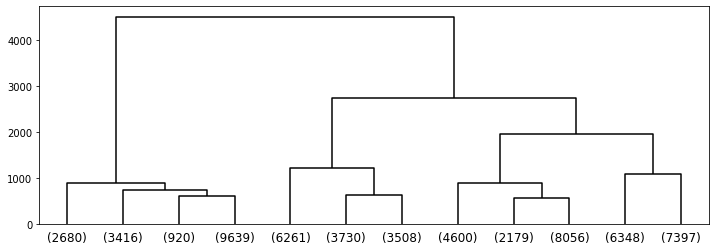

In [43]:
fig = plt.figure(figsize=(12,4))
plot_dendrogram(clustering, truncate_mode='lastp', p=12,
                above_threshold_color='black',color_threshold=12)
plt.show()

### Get RGB data

In [47]:
def zscore(data):
    return (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))

In [48]:
def proc_msds(sds_array):
    """
    Multi-band
    IN: array = hdf_data.select(variable_name)
    """
    array = sds_array.get()
    array = array.astype(np.float64)
    
    # check bandinfo
    _bands = sds_array.attributes()['band_names']
    #print("Process bands", _bands)
    bands = _bands.split(",")
    
    # nan process
    nan_idx = np.where( array == sds_array.attributes()['_FillValue'])
    if len(nan_idx) > 0:
        array[nan_idx] = np.nan
    else:
        pass
    # invalid value process
    # TODO: future change 32767 to other value
    invalid_idx = np.where( array > 32767 )
    if len(nan_idx) > 0:
        array[invalid_idx] = np.nan
    else:
        pass
    
    # radiacne offset
    offset = sds_array.attributes()['radiance_offsets']
    offset_array = np.zeros(array.shape) # new matrix
    offset_ones  = np.ones(array.shape)  # 1 Matrix 
    for iband in range(len(offset)):
        offset_array[iband, :,:] = array[iband, :,:] - offset[iband]*offset_ones[iband,:,:]
    
    # radiance scale
    scales = sds_array.attributes()['radiance_scales']
    scales_array = np.zeros(array.shape) # new matrix
    for iband in range(len(offset)):
        scales_array[iband,:,:] = scales[iband]*offset_array[iband,:,:]
    return scales_array, bands

In [49]:
hdf_datadir='/home/tkurihana/hdd1/data/MYD02/20080101'

In [50]:
clouds_vimgs = []
idx = 20
h=w=128
for idx, i in enumerate(fileorder):
    fbasename = os.path.basename(i).rstrip('.tfrecord')
    fbname = re.findall(r'A[0-9]{7}.[0-9]{4}', fbasename)[0].split('.')
    ctime = fbname[1]
    # HDF data
    try:
        vis_file = glob.glob(os.path.join(hdf_datadir,
                        f"MYD021KM.A2008001.{ctime}.*.hdf"
                       ))[0]
        vhdf = SD(vis_file, SDC.READ)
        vhdf_sds250 = vhdf.select("EV_250_Aggr1km_RefSB")
        #vhdf_sds500 = vhdf.select("EV_500_Aggr1km_RefSB")
        v250,_ = proc_msds(vhdf_sds250)
        #v500,_ = proc_msds(vhdf_sds500)
        
        vhdf_array = zscore(v250[0])
        #v_r = zscore(v250[0])
        #v_g = zscore(v500[1])
        #v_b = zscore(v500[0])
        #vhdf_array = np.concatenate(
        #    [np.expand_dims(v_r,axis=-1), 
        #     np.expand_dims(v_g,axis=-1),
        #     np.expand_dims(v_b,axis=-1)],axis=-1
        #)
        
        
        for coord in coords_list[idx]:
            x= coord[0]
            y= coord[1]
            im = Image.fromarray(np.uint8(vhdf_array[x:x+h,y:y+w]*255)).convert('RGB')
            clouds_vimgs.append( im )
    
        if idx % 20 == 0:
            print(f"{idx} files read done!", flush=True)
            gc.collect()
    except Exception as e:
        print(e)

0 files read done!


/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


20 files read done!
40 files read done!
60 files read done!
80 files read done!
100 files read done!
120 files read done!
140 files read done!


### Plot

In [39]:
patches.shape

(58734, 128, 128, 6)

### using band 5

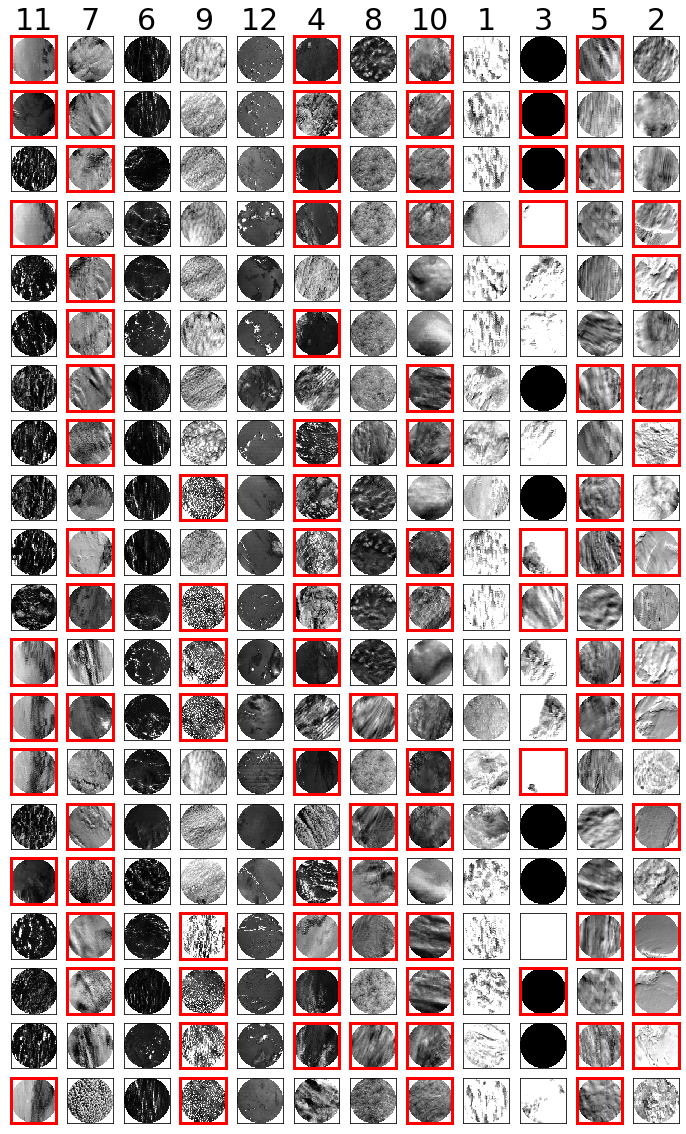

In [58]:
fsize=30
savedir = './figs'
isize=20
fig,ax = plt.subplots(20,12,figsize=(12,20))
for i, num_icluster in enumerate(num_cdata):
    icluster = icluster_list.index(num_icluster)
    tmps = dict_topNs[f'cluster-{icluster}']
    cdx = np.where(clabels == icluster)
    for j in range(isize):
            index = cdx[0][tmps[j][0]]
            ax[j,i].imshow(patches[index,:,:,0]*nan_mask,cmap='gist_gray' )
            ax[j,i].xaxis.set_visible(False)
            ax[j,i].yaxis.set_visible(False)
            if j == 0:
                ax[0,i].set_title(f'{icluster+1}', fontsize=fsize)
            if land_flags[index] == 1:
                for ip in ['top', 'bottom', 'left', 'right']:
                    ax[j,i].spines[f"{ip}"].set_color("red")
                    ax[j,i].spines[f"{ip}"].set_linewidth(3)
                
plt.show()
    #ax.set_ylabel('Bhattacharyya',fontsize=20)
#pdf = PdfPages(os.path.join(savedir, "cumuloimage_12_2008Jan01_top40.pdf") )
#plt.savefig(pdf, format='pdf', bbox_inches='tight')
#pdf.close()
#pdf = None

Using band 7

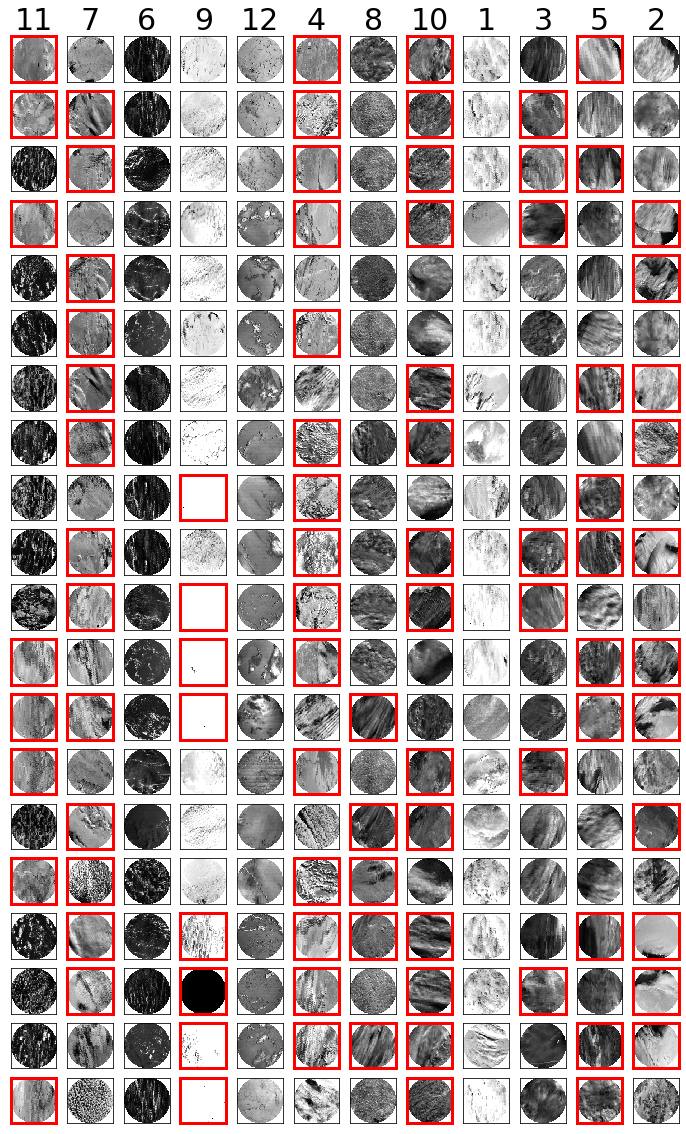

In [65]:
fsize=30
savedir = './figs'
isize=20
fig,ax = plt.subplots(20,12,figsize=(12,20))
for i, num_icluster in enumerate(num_cdata):
    icluster = icluster_list.index(num_icluster)
    tmps = dict_topNs[f'cluster-{icluster}']
    cdx = np.where(clabels == icluster)
    for j in range(isize):
            index = cdx[0][tmps[j][0]]
            ax[j,i].imshow(patches[index,:,:,1]*nan_mask,cmap='gist_gray' )
            ax[j,i].xaxis.set_visible(False)
            ax[j,i].yaxis.set_visible(False)
            if j == 0:
                ax[0,i].set_title(f'{icluster+1}', fontsize=fsize)
            if land_flags[index] == 1:
                for ip in ['top', 'bottom', 'left', 'right']:
                    ax[j,i].spines[f"{ip}"].set_color("red")
                    ax[j,i].spines[f"{ip}"].set_linewidth(3)
                
plt.show()

### band 1 (RI autoencoder)

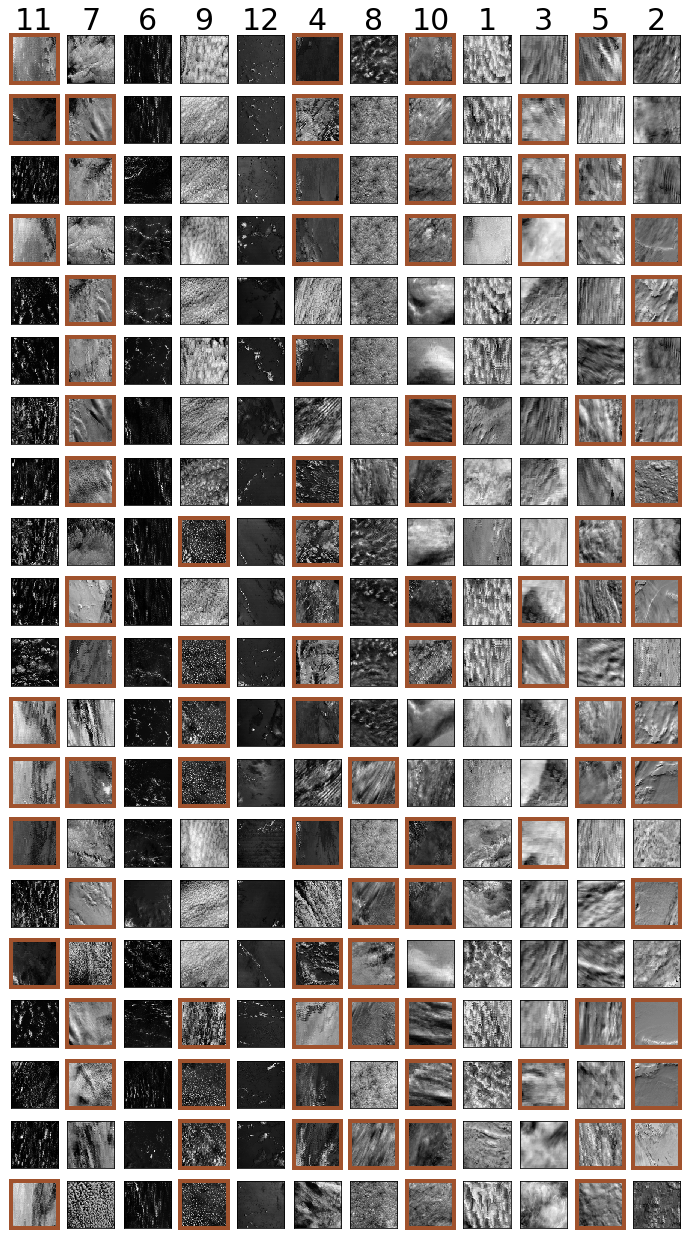

In [72]:
fsize=30
savedir = './figs'
isize=20
fig,ax = plt.subplots(20,12,figsize=(12,22))
for i, num_icluster in enumerate(num_cdata):
    icluster = icluster_list.index(num_icluster)
    tmps = dict_topNs[f'cluster-{icluster}']
    cdx = np.where(clabels == icluster)
    for j in range(isize):
            index = cdx[0][tmps[j][0]]
            ax[j,i].imshow(np.asarray(clouds_vimgs[index])[:,:,0],cmap='gist_gray' )
            ax[j,i].xaxis.set_visible(False)
            ax[j,i].yaxis.set_visible(False)
            if j == 0:
                ax[0,i].set_title(f'{icluster+1}', fontsize=fsize)
            if land_flags[index] == 1:
                for ip in ['top', 'bottom', 'left', 'right']:
                    ax[j,i].spines[f"{ip}"].set_color("sienna")
                    ax[j,i].spines[f"{ip}"].set_linewidth(4)
            #elif land_flags[index] == 0:
            #    for ip in ['top', 'bottom', 'left', 'right']:
            #        ax[j,i].spines[f"{ip}"].set_color("blue")
            #        ax[j,i].spines[f"{ip}"].set_linewidth(3)
                
plt.show()

### band 1 (NRI autoencoder)

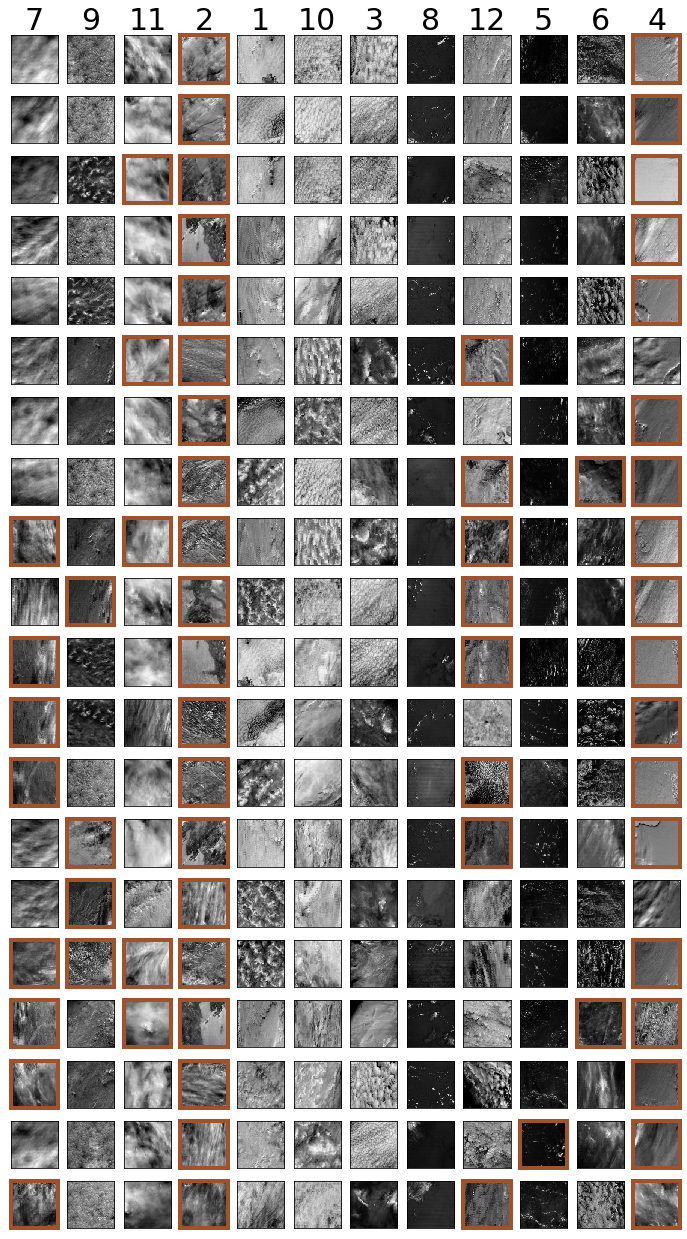

In [56]:
fsize=30
savedir = './figs'
isize=20
fig,ax = plt.subplots(20,12,figsize=(12,22))
for i, num_icluster in enumerate(num_cdata):
    icluster = icluster_list.index(num_icluster)
    tmps = dict_topNs[f'cluster-{icluster}']
    cdx = np.where(clabels == icluster)
    for j in range(isize):
            index = cdx[0][tmps[j][0]]
            ax[j,i].imshow(np.asarray(clouds_vimgs[index])[:,:,0],cmap='gist_gray' )
            ax[j,i].xaxis.set_visible(False)
            ax[j,i].yaxis.set_visible(False)
            if j == 0:
                ax[0,i].set_title(f'{icluster+1}', fontsize=fsize)
            if land_flags[index] == 1:
                for ip in ['top', 'bottom', 'left', 'right']:
                    ax[j,i].spines[f"{ip}"].set_color("sienna")
                    ax[j,i].spines[f"{ip}"].set_linewidth(4)
            #elif land_flags[index] == 0:
            #    for ip in ['top', 'bottom', 'left', 'right']:
            #        ax[j,i].spines[f"{ip}"].set_color("blue")
            #        ax[j,i].spines[f"{ip}"].set_linewidth(3)
                
plt.show()